# Projection data 

In [51]:
import xarray as xr
import numpy as np
import rioxarray
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
import pandas as pd
import func
import cftime

In [77]:
TempProj = rioxarray.open_rasterio('/Volumes/Camtasia/projections/tas_CentralEurope_0.5x0.5degrees_downscaled.nc')
LaiProj = rioxarray.open_rasterio('/Volumes/Camtasia/projections/lai_CentralEurope_0.5x0.5degrees_downscaled.nc')
PrecProj = rioxarray.open_rasterio('/Volumes/Camtasia/projections/pr_CentralEurope_0.5x0.5degrees_downscaled.nc')
RadProj = rioxarray.open_rasterio('/Volumes/Camtasia/projections/rls_CentralEurope_0.5x0.5degrees_downscaled.nc')

# Forcing data

In [81]:
years = np.arange(2000, 2024, 1)
P_data = []
R_data = []
T_data = []
lai_data = []
calibration_time = [2000, 2010]

for year in years:
    file_path = 'data/total_precipitation/tp.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    P_data.append(xr.open_dataset(file_path)['tp'])

    file_path = 'data/net_radiation/nr.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    R_data.append(xr.open_dataset(file_path)['nr'])

    file_path = 'data/daily_average_temperature/t2m_mean.daily.calc.era5.0d50_CentralEurope.' + str(year) + '.nc'
    T_data.append(xr.open_dataset(file_path)['t2m'])

    file_path = 'data/lai/lai.daily.0d50_CentralEurope.' + str(year) + '.nc'
    lai_data.append(xr.open_dataset(file_path)['lai'])

# Convert lists to xarray datasets
P_data = xr.concat(P_data, dim='time')
R_data = xr.concat(R_data, dim='time')
T_data = xr.concat(T_data, dim='time')
lai_data = xr.concat(lai_data, dim='time')

## Cropping and interpolating Projections Data

### Precipitation, radiation, lai

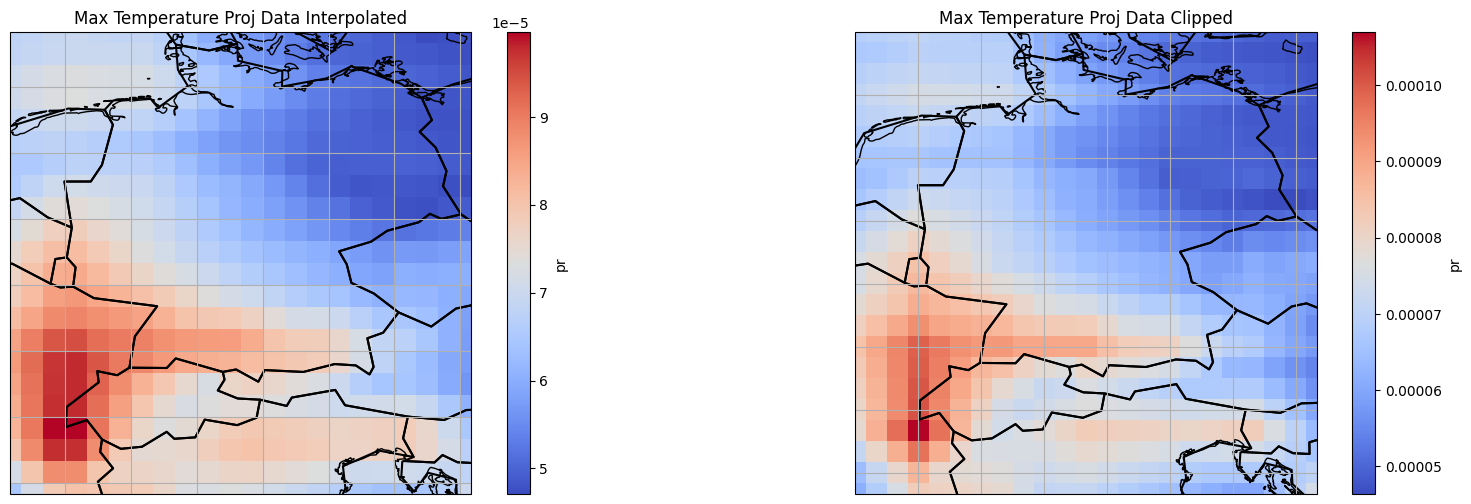

In [224]:
PrecProj_clipped, PrecProj_interp = func.clip_proj(P_data, PrecProj)
func.plot_proj_data(PrecProj_interp, PrecProj_clipped, world)

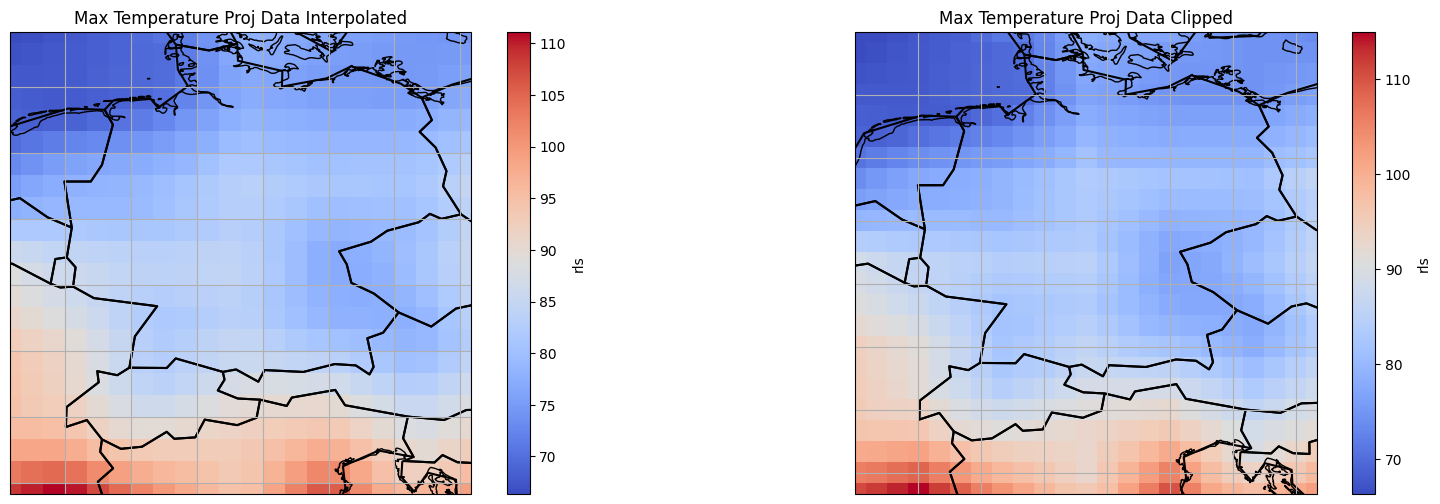

In [262]:
RadProj_clipped, RadProj_interp = func.clip_proj(R_data, RadProj)
func.plot_proj_data(RadProj_interp, RadProj_clipped, world)

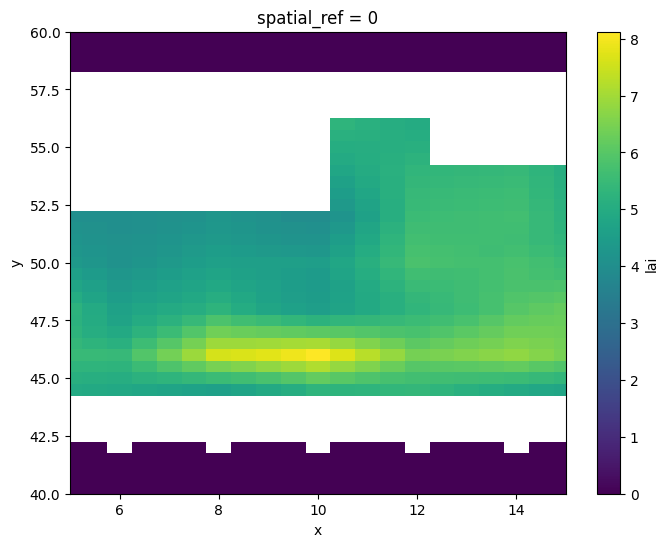

In [228]:
# lai data is incomplete

plt.figure(figsize=(8, 6))
LaiProj.max(dim='time').plot()

# Set the limits for y-axis and x-axis
plt.ylim([40, 60])  # Set the limits for y-axis
plt.xlim([5, 15])  # Set the limits for x-axis

plt.show()

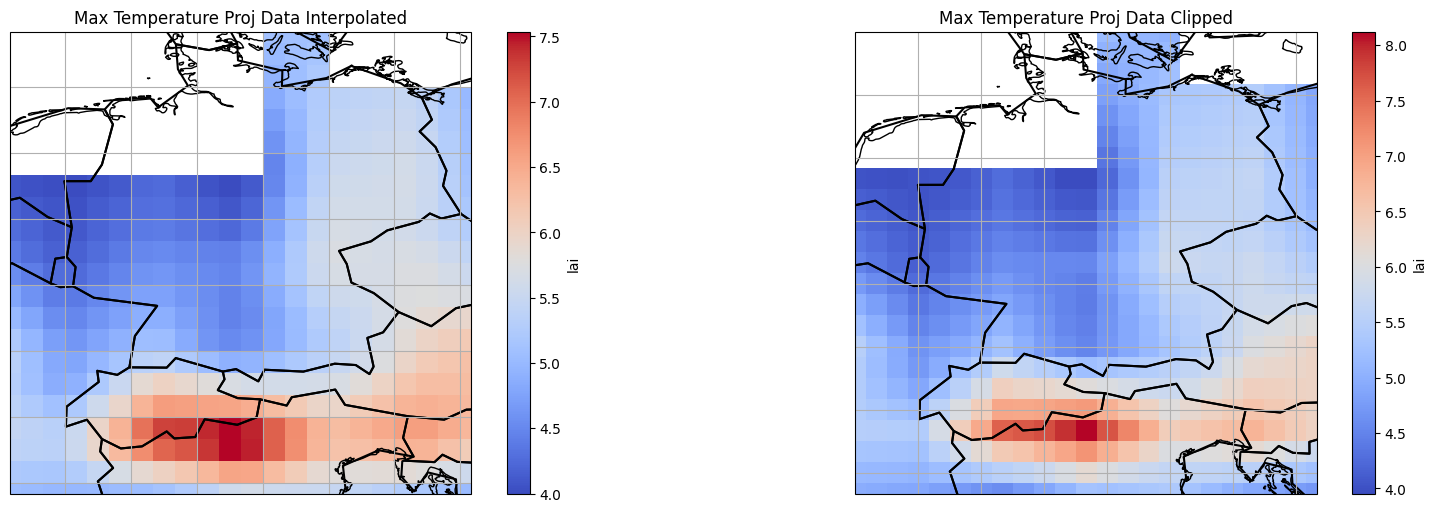

In [226]:
LaiProj_clipped, LaiProj_interp = func.clip_proj(lai_data, LaiProj)
func.plot_proj_data(LaiProj_interp, LaiProj_clipped, world)

### Temperature (long version)

In [166]:
min_lon = T_data.lon.min().values - 0.5
min_lat = T_data.lat.min().values - 0.5
max_lon = T_data.lon.max().values + 0.5
max_lat = T_data.lat.max().values + 0.5

In [167]:
TempProj_clipped = TempProj.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)

/var/folders/4d/mr8xjpxx019_krc9fm5bmgv40000gn/T/ipykernel_912/1394009193.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


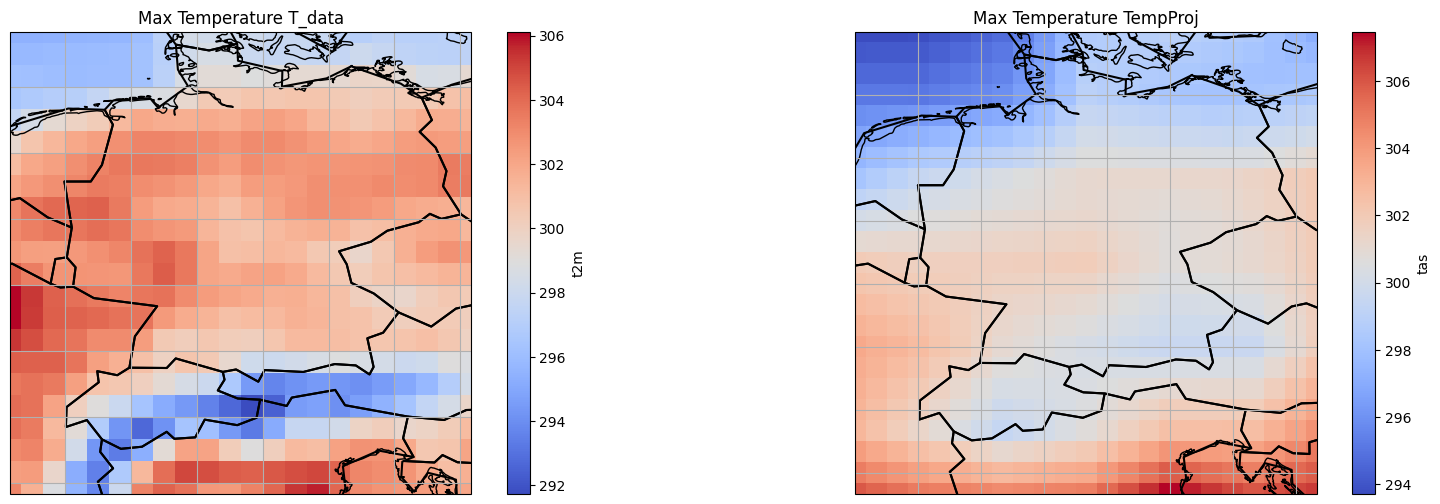

In [169]:
# Load the country boundaries shapefile using geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Get the extent of the raster data
extent_T_data = [
    T_data.lon.min(),
    T_data.lon.max(),
    T_data.lat.min(),
    T_data.lat.max()
]

extent_TempProj_clipped = [
    TempProj_clipped.x.min(),
    TempProj_clipped.x.max(),
    TempProj_clipped.y.min(),
    TempProj_clipped.y.max()
]

# Create a new figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the raster data and country boundaries for T_data
T_data.max(dim='time').plot(ax=ax1, cmap='coolwarm')
world.boundary.plot(ax=ax1, linewidth=1.5, color='black')
ax1.set_extent(extent_T_data)
ax1.set_title('Max Temperature T_data')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.coastlines()
ax1.gridlines()

# Plot the raster data and country boundaries for TempProj_clipped
TempProj_clipped.max(dim='time').plot(ax=ax2, cmap='coolwarm')
world.boundary.plot(ax=ax2, linewidth=1.5, color='black')
ax2.set_extent(extent_TempProj_clipped)
ax2.set_title('Max Temperature TempProj')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.coastlines()
ax2.gridlines()

# Show the plot
plt.show()


In [170]:
TempProj_interp = TempProj_clipped.rename({'x': 'lon', 'y': 'lat'})

TempProj_interp = TempProj_interp.interp(
    lon=T_data.lon,
    lat=T_data.lat,
    method='linear'
)

/var/folders/4d/mr8xjpxx019_krc9fm5bmgv40000gn/T/ipykernel_912/1839751751.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


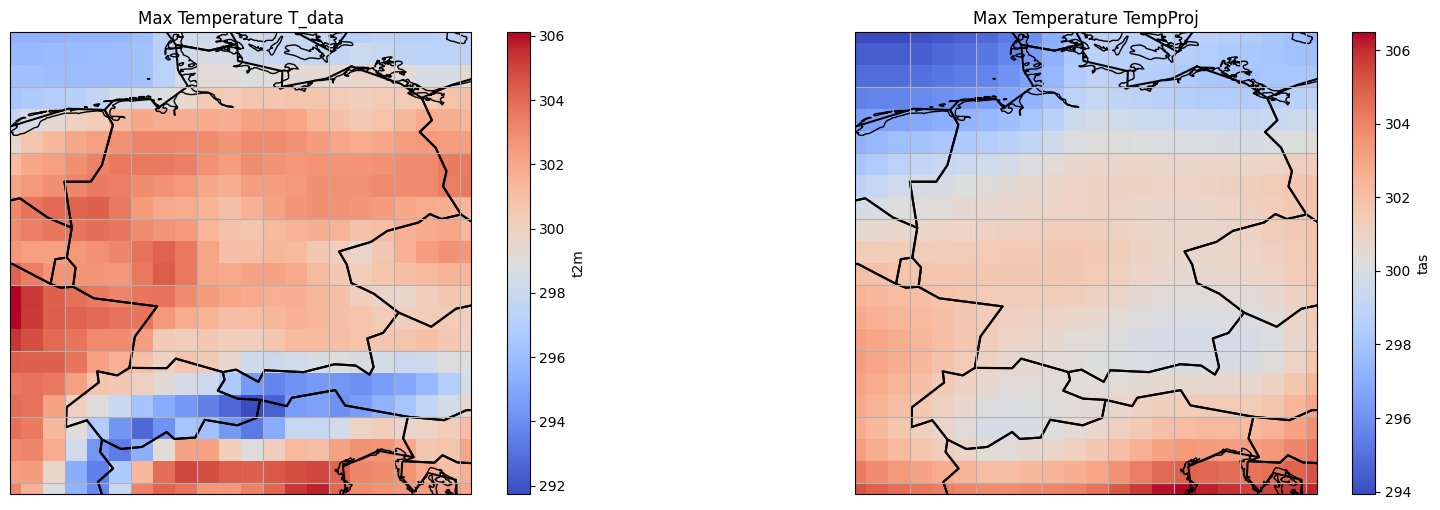

In [173]:
# Load the country boundaries shapefile using geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Get the extent of the raster data
extent_T_data = [
    T_data.lon.min(),
    T_data.lon.max(),
    T_data.lat.min(),
    T_data.lat.max()
]

extent_TempProj_clipped = [
    TempProj_interp.lon.min(),
    TempProj_interp.lon.max(),
    TempProj_interp.lat.min(),
    TempProj_interp.lat.max()
]

# Create a new figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the raster data and country boundaries for T_data
T_data.max(dim='time').plot(ax=ax1, cmap='coolwarm')
world.boundary.plot(ax=ax1, linewidth=1.5, color='black')
ax1.set_extent(extent_T_data)
ax1.set_title('Max Temperature T_data')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.coastlines()
ax1.gridlines()

# Plot the raster data and country boundaries for TempProj_clipped
TempProj_interp.max(dim='time').plot(ax=ax2, cmap='coolwarm')
world.boundary.plot(ax=ax2, linewidth=1.5, color='black')
ax2.set_extent(extent_TempProj_clipped)
ax2.set_title('Max Temperature TempProj')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.coastlines()
ax2.gridlines()

# Show the plot
plt.show()


/var/folders/4d/mr8xjpxx019_krc9fm5bmgv40000gn/T/ipykernel_912/1905263065.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


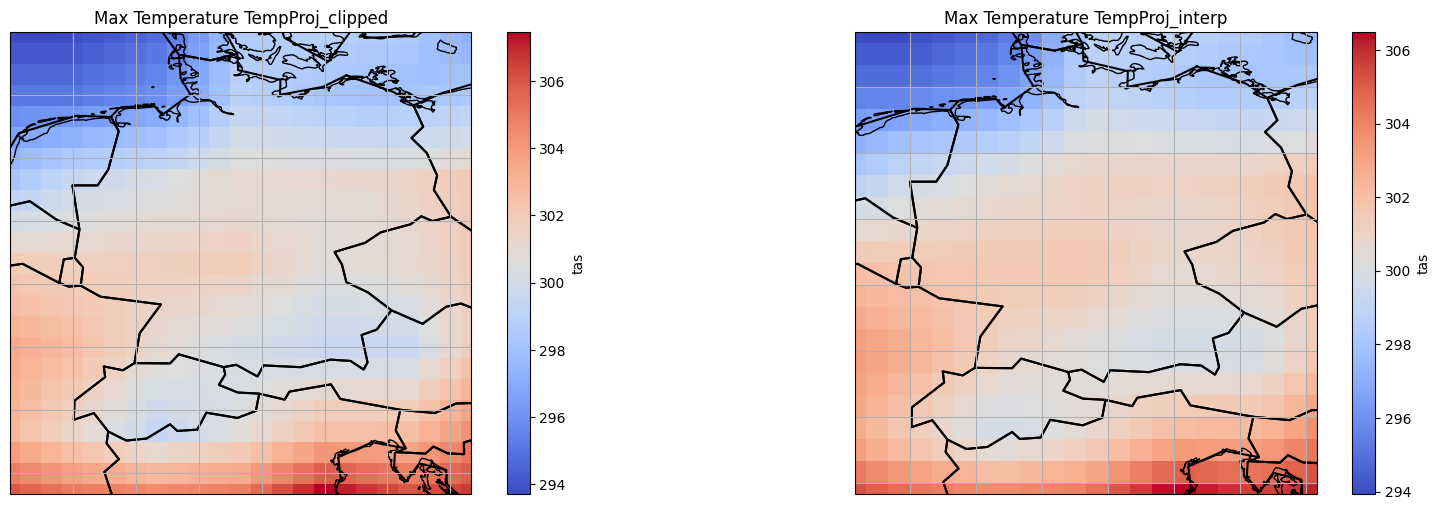

In [174]:
# Load the country boundaries shapefile using geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Get the extent of the raster data
extent_TempProj_clipped = [
    TempProj_clipped.x.min(),
    TempProj_clipped.x.max(),
    TempProj_clipped.y.min(),
    TempProj_clipped.y.max()
]

extent_TempProj_interp = [
    TempProj_interp.lon.min(),
    TempProj_interp.lon.max(),
    TempProj_interp.lat.min(),
    TempProj_interp.lat.max()
]

# Create a new figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the raster data and country boundaries for TempProj_clipped
TempProj_clipped.max(dim='time').plot(ax=ax1, cmap='coolwarm')
world.boundary.plot(ax=ax1, linewidth=1.5, color='black')
ax1.set_extent(extent_TempProj_clipped)
ax1.set_title('Max Temperature TempProj_clipped')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.coastlines()
ax1.gridlines()

# Plot the raster data and country boundaries for TempProj_interp
TempProj_interp.max(dim='time').plot(ax=ax2, cmap='coolwarm')
world.boundary.plot(ax=ax2, linewidth=1.5, color='black')
ax2.set_extent(extent_TempProj_interp)
ax2.set_title('Max Temperature TempProj_interp')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.coastlines()
ax2.gridlines()

# Show the plot
plt.show()


# Offset


In [257]:
TempProj_corrected = func.correct_temporal_bias(TempProj_interp, T_data)
PrecProj_corrected = func.correct_temporal_bias(PrecProj_interp, P_data)

RadProj_converted = RadProj_interp * 86400
RadProj_corrected = func.correct_temporal_bias(RadProj_converted, R_data)

LaiProj_corrected = func.correct_temporal_bias(LaiProj_interp, lai_data)

Mean Difference Over All Pixels: 1.2781354487976833


In [268]:
TempProj_corrected.to_netcdf('data/projections/Temperature_2000_2100_cropped_offset.nc')
PrecProj_corrected.to_netcdf('data/projections/Precipitation_2000_2100_cropped_offset.nc')
LaiProj_corrected.to_netcdf('data/projections/LeafAreaIndex_2000_2100_cropeed_offset.nc')
RadProj_corrected.to_netcdf('data/projections/RadiationRLS_2000_2100_cropeed_offset.nc')

# Create daily data

In [278]:
# neu einladen
lai_future = xr.open_dataarray("data/projections/LeafAreaIndex_2000_2100_cropeed_offset.nc")
T_future = xr.open_dataarray("data/projections/Temperature_2000_2100_cropped_offset.nc")
R_future = xr.open_dataarray("data/projections/RadiationRLS_2000_2100_cropeed_offset.nc")
P_future = xr.open_dataarray("data/projections/Precipitation_2000_2100_cropped_offset.nc")

In [285]:
T_future

<xarray.DataArray 'tas' (time: 1212, lat: 22, lon: 22)> Size: 5MB
[586608 values with dtype=float64]
Coordinates:
  * time         (time) object 10kB 2000-01-15 12:00:00 ... 2100-12-15 12:00:00
    spatial_ref  int64 8B ...
  * lon          (lon) float64 176B 4.75 5.25 5.75 6.25 ... 14.25 14.75 15.25
  * lat          (lat) float64 176B 55.25 54.75 54.25 ... 45.75 45.25 44.75

In [356]:
new_time_range = pd.date_range(start='2000-01-01', end='2100-12-31', freq = 'M')
T_future['time'] = new_time_range
len(new_time_range)

1212

In [357]:
# Convert 'time' attribute to Pandas DateTimeIndex
time_index = pd.to_datetime(T_future.time.values)

# Extract the number of days in each month directly from the timestamps
days_in_month = pd.DatetimeIndex(time_index).days_in_month

# Initialize an empty list to store daily dates
daily_dates = []

# Iterate through each month and generate daily dates
for idx, num_days in enumerate(days_in_month):
    # Get the start date of the month
    start_date = time_index[idx]
    # Create daily DateTimeIndex for the month
    month_dates = pd.date_range(start=start_date, periods=num_days, freq='D')
    # Append to the list of daily dates
    daily_dates.extend(month_dates)

# Convert the list of daily dates to DateTimeIndex
daily_dates_index = pd.DatetimeIndex(daily_dates)

# Repeat the last value of each month for the remaining days in that month
T_future_daily = np.repeat(T_future, days_in_month, axis=0)

# Assign daily dates to the 'time' coordinate
T_future_daily['time'] = daily_dates_index

# Verify the shape of the resulting array
print(T_future_daily.shape)


(36890, 22, 22)


In [354]:
# Convert 'time' attribute to Pandas DateTimeIndex
time_index = pd.to_datetime(T_future.time.values)

# Extract the number of days in each month directly from the timestamps
days_in_month = pd.DatetimeIndex(time_index).days_in_month

# Initialize an empty list to store daily dates
daily_dates = []

# Iterate through each month and generate daily dates
for idx, num_days in enumerate(days_in_month):
    # Get the start date of the month
    start_date = time_index[idx]
    # Create daily DateTimeIndex for the month
    month_dates = pd.date_range(start=start_date, periods=num_days, freq='D')
    # Append to the list of daily dates
    daily_dates.extend(month_dates)

# Convert the list of daily dates to DateTimeIndex
daily_dates_index = pd.DatetimeIndex(daily_dates)

# Repeat the last value of each month for the remaining days in that month
T_future_daily = np.repeat(T_future, days_in_month, axis=0)

# Assign daily dates to the 'time' coordinate
T_future_daily['time'] = daily_dates_index

# Verify the shape of the resulting array
print(T_future_daily.shape)

(37572, 22, 22)


In [358]:
T_future_daily

<xarray.DataArray 'tas' (time: 36890, lat: 22, lon: 22)> Size: 143MB
array([[[279.0250338 , 278.88707909, 278.74909386, ..., 275.31283745,
         275.40799126, 275.50199303],
        [279.01798424, 278.88514122, 278.75227532, ..., 275.59352288,
         275.57954583, 275.56440911],
        [279.01047692, 278.88255486, 278.75512108, ..., 275.87352166,
         275.74968132, 275.62574181],
        ...,
        [276.04793724, 275.40618309, 274.76176628, ..., 274.52260002,
         274.69992241, 274.87022576],
        [276.51488671, 275.93873772, 275.35992607, ..., 276.12829003,
         276.10020623, 276.06511101],
        [276.98179802, 276.47124657, 275.95804772, ..., 277.73385033,
         277.5003756 , 277.25991234]],

       [[279.0250338 , 278.88707909, 278.74909386, ..., 275.31283745,
         275.40799126, 275.50199303],
        [279.01798424, 278.88514122, 278.75227532, ..., 275.59352288,
         275.57954583, 275.56440911],
        [279.01047692, 278.88255486, 278.75512108, ..., 275.87352166,
         275.74968132, 275.62574181],
...
        [280.49504265, 279.88378319, 279.2689074 , ..., 280.13154778,
         280.31696495, 280.49426445],
        [281.18860039, 280.63926873, 280.08632836, ..., 281.9877871 ,
         281.9504641 , 281.90504631],
        [281.88211235, 281.39470085, 280.90368828, ..., 283.84389672,
         283.5838488 , 283.31572136]],

       [[282.85030541, 282.79405388, 282.73755822, ..., 278.91829857,
         279.15095696, 279.38149437],
        [282.92756829, 282.86235985, 282.79690728, ..., 279.43412957,
         279.51925072, 279.6022509 ],
        [283.00373253, 282.92933831, 282.85563073, ..., 279.94870934,
         279.88487419, 279.82079491],
        ...,
        [280.49504265, 279.88378319, 279.2689074 , ..., 280.13154778,
         280.31696495, 280.49426445],
        [281.18860039, 280.63926873, 280.08632836, ..., 281.9877871 ,
         281.9504641 , 281.90504631],
        [281.88211235, 281.39470085, 280.90368828, ..., 283.84389672,
         283.5838488 , 283.31572136]]])
Coordinates:
    spatial_ref  int64 8B ...
  * lon          (lon) float64 176B 4.75 5.25 5.75 6.25 ... 14.25 14.75 15.25
  * lat          (lat) float64 176B 55.25 54.75 54.25 ... 45.75 45.25 44.75
  * time         (time) datetime64[ns] 295kB 2000-01-31 ... 2101-01-30